In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from experiments.utils.experiment_utils import add_to_diagonal, log_likelihood, ecdf

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Negligible but good for portfolio construction

In [4]:
returns = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

ewma = returns.ewm(halflife=21, min_periods=5).mean().shift(1).dropna()
returns = returns.loc[ewma.index]

# end at 1990
start_date = pd.to_datetime("2000-01-01", format="%Y-%m-%d")
# end_date = pd.to_datetime("2005-12-31", format="%Y-%m-%d")

ewma = ewma.loc[start_date:]
returns = returns.loc[start_date:]

In [5]:
### No mean adjustment
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_no_mean = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

In [6]:
### With mean adjustment
cov_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]
mean_pairs = [(5,5), (10,10), (21,21), (63,63), (125,125)]

# CM-IEWMA
iewmas = {i: list(iterated_ewma(returns, vola_halflife=cov_pairs[i][0], cov_halflife=cov_pairs[i][1], min_periods_vola=63, min_periods_cov=63, mean=True, mu_halflife1=mean_pairs[i][0], mu_halflife2=mean_pairs[i][1])) for i in range(5)}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
mus = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast =0
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_with_mean = list(from_sigmas(Sigmas, returns, means=mus).solve(window=10))

In [5]:
# covariance_no_mean = {result.time: result.covariance for result in results_no_mean}
# weights_no_mean = {result.time: result.weights for result in results_no_mean}


In [7]:
covariance_no_mean = {result.time: result.covariance for result in results_no_mean}
weights_no_mean = {result.time: result.weights for result in results_no_mean}

covariance_with_mean = {result.time: result.covariance for result in results_with_mean}
weights_with_mean = {result.time: result.weights for result in results_with_mean}

cm_iewma_mean = pd.DataFrame({result.time: result.mean for result in results_with_mean}).T

In [8]:
# start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
start_date = list(covariance_no_mean.keys())[0]
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

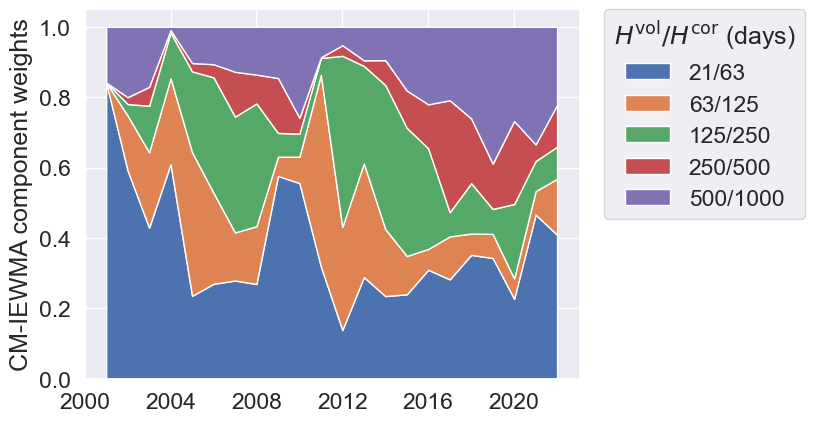

In [8]:
yearly_weights  = pd.DataFrame(weights_no_mean).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

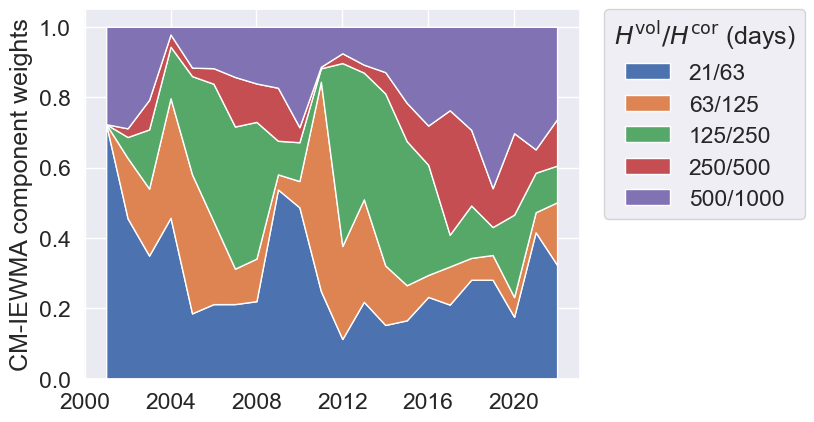

In [9]:
yearly_weights  = pd.DataFrame(weights_with_mean).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

# Mean variance portfolio

In [10]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

def tune_returns2(returns):
    """
    For each r in returns, makes the 5% biggest values 1 (if they are positive) and the 5%
    smallest -1 (if they are negative)
    """  
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.where(r_temp > r_temp.quantile(0.9), 1, np.where(r_temp < r_temp.quantile(0.1), -1, 0))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)



In [21]:

# r_hat_ewma1 = tune_returns(pd.DataFrame(dict(_ewma_mean(returns, halflife=1))).T)
r_hat_ewma5 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=5))).T)
r_hat_ewma10 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=10))).T)
r_hat_ewma21 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=21))).T)
r_hat_ewma63 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=63))).T)
r_hat_ewma125 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=125))).T)
r_hat_ewma250 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=250))).T)
# r_hat_ewma500 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=500))).T)
# r_hat_ewma1000 = (pd.DataFrame(dict(_ewma_mean(returns, halflife=1000))).T)

# cm_iewma_mean_tuned = tune_returns(cm_iewma_mean)


mean_predictors = [cm_iewma_mean]
cov_predictors = [covariance_no_mean]

In [22]:
from experiments.utils.portfolio_backtests import MeanVariance

names = ["EWMA-5", "EWMA-10", "EWMA-21", "EWMA-63", "EWMA-125", "EWMA-250", "CM-IEWMA"]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

traders_mean_var = MeanVariance(returns, cov_predictors[:], names, mean_predictors=mean_predictors[:], start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 1/1 [00:33<00:00, 33.43s/it]


In [23]:
rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess=False

# Predictors +1 for top 10% -1 for bottom 10%
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-5 & 3.9\% & 2.1\% & 1.8 & 3\% \\
   \hline
   \bottomrule
\end{tabular}


In [20]:
rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess=False

# Predictors +1 for top 10% -1 for bottom 10%
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-5 & 3.5\% & 2.1\% & 1.7 & 5\% \\
   EWMA-10 & 3.8\% & 2.1\% & 1.8 & 3\% \\
   EWMA-21 & 3.8\% & 2.2\% & 1.7 & 4\% \\
   EWMA-63 & 3.6\% & 2.2\% & 1.7 & 4\% \\
   EWMA-125 & 3.4\% & 2.2\% & 1.6 & 4\% \\
   EWMA-250 & 2.9\% & 2.2\% & 1.3 & 6\% \\
   CM-IEWMA & 4.0\% & 2.3\% & 1.7 & 4\% \\
   \hline
   \bottomrule
\end{tabular}


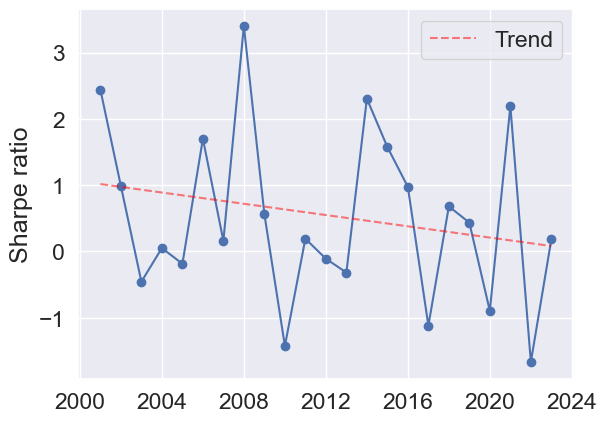

In [103]:
from experiments.utils.experiment_utils import yearly_SR
trader = traders_mean_var["EWMA-250"]
trader.returns = trader.R
SR = yearly_SR(trader)

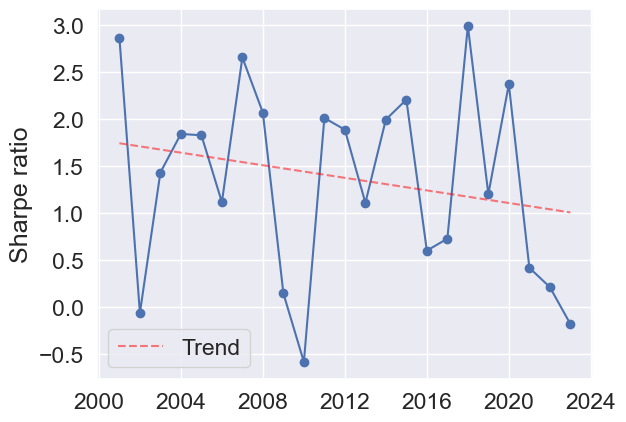

In [58]:
from experiments.utils.experiment_utils import yearly_SR
trader = traders_mean_var["EWMA-250"]
trader.returns = trader.R
SR = yearly_SR(trader)

In [25]:
from experiments.utils.portfolio_backtests import create_table
rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess=True

# Predictors +1 for top 10% -1 for bottom 10%
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-63 & 4.2\% & 5.9\% & 0.7 & 12\% \\
   EWMA-125 & 3.9\% & 5.9\% & 0.7 & 13\% \\
   EWMA-250 & 5.2\% & 5.7\% & 0.9 & 13\% \\
   EWMA-500 & 5.0\% & 5.6\% & 0.9 & 10\% \\
   EWMA-1000 & 4.5\% & 5.5\% & 0.8 & 15\% \\
   CM-IEWMA (for mean only) & 3.8\% & 5.9\% & 0.6 & 15\% \\
   CM-IEWMA & 3.8\% & 6.1\% & 0.6 & 16\% \\
   \hline
   \bottomrule
\end{tabular}


In [18]:
from experiments.utils.portfolio_backtests import create_table
rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess=True

# Predictors +1 for top 10% -1 for bottom 10%
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-1 & -0.8\% & 5.5\% & -0.1 & 29\% \\
   EWMA-5 & 2.3\% & 5.5\% & 0.4 & 21\% \\
   EWMA-10 & 2.6\% & 5.6\% & 0.5 & 22\% \\
   EWMA-21 & 2.6\% & 5.7\% & 0.5 & 19\% \\
   EWMA-63 & 4.8\% & 5.8\% & 0.8 & 12\% \\
   EWMA-125 & 4.6\% & 5.8\% & 0.8 & 13\% \\
   EWMA-250 & 5.7\% & 5.7\% & 1.0 & 13\% \\
   EWMA-500 & 5.4\% & 5.6\% & 1.0 & 12\% \\
   CM-IEWMA & 3.8\% & 5.9\% & 0.7 & 14\% \\
   \hline
   \bottomrule
\end{tabular}


In [52]:
from experiments.utils.portfolio_backtests import create_table
rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess=True

# Predictors cut at 60th percentila
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-1 & -0.8\% & 5.5\% & -0.1 & 29\% \\
   EWMA-5 & 2.3\% & 5.5\% & 0.4 & 21\% \\
   EWMA-10 & 2.6\% & 5.6\% & 0.5 & 22\% \\
   EWMA-21 & 2.6\% & 5.7\% & 0.5 & 19\% \\
   EWMA-63 & 4.8\% & 5.8\% & 0.8 & 12\% \\
   EWMA-125 & 4.6\% & 5.8\% & 0.8 & 13\% \\
   EWMA-250 & 5.7\% & 5.7\% & 1.0 & 13\% \\
   EWMA-500 & 5.4\% & 5.6\% & 1.0 & 12\% \\
   \hline
   \bottomrule
\end{tabular}


In [69]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-1 & 1.5\% & 5.7\% & 0.3 & 16\% \\
   EWMA-5 & 1.3\% & 5.9\% & 0.2 & 14\% \\
   EWMA-10 & 0.3\% & 6.0\% & 0.0 & 16\% \\
   EWMA-21 & -0.8\% & 6.2\% & -0.1 & 26\% \\
   EWMA-63 & -3.4\% & 6.5\% & -0.5 & 50\% \\
   EWMA-125 & -4.3\% & 6.5\% & -0.7 & 55\% \\
   EWMA-250 & -4.5\% & 6.3\% & -0.7 & 56\% \\
   EWMA-500 & -4.1\% & 5.9\% & -0.7 & 54\% \\
   \hline
   \bottomrule
\end{tabular}


In [276]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_min_risk, 0.05, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 4.4\% & 5.4\% & 0.8 & 15\% \\
   \hline
   \bottomrule
\end{tabular}


In [141]:
start_date = mean_predictors[-1].index[0]
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")
traders_mean_var_temp = MeanVariance(returns, [cov_predictors[0]], names, mean_predictors=[mean_predictors[-1]], start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 1/1 [05:13<00:00, 313.50s/it]


In [271]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 0.9\% & 6.2\% & 0.1 & 18\% \\
   EWMA-63 & 3.5\% & 6.5\% & 0.5 & 16\% \\
   EWMA-125 & 4.4\% & 6.5\% & 0.7 & 19\% \\
   EWMA-250 & 4.6\% & 6.3\% & 0.7 & 21\% \\
   EWMA-500 & 4.3\% & 5.9\% & 0.7 & 19\% \\
   CM-IEWMA & 3.2\% & 6.8\% & 0.5 & 18\% \\
   \hline
   \bottomrule
\end{tabular}


In [142]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var_temp, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 10.1\% & 6.0\% & 1.7 & 18\% \\
   \hline
   \bottomrule
\end{tabular}


In [13]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 5.1\% & 5.7\% & 0.9 & 18\% \\
   EWMA-63 & 10.8\% & 6.6\% & 1.6 & 19\% \\
   \hline
   \bottomrule
\end{tabular}


In [33]:
from experiments.utils.portfolio_backtests import MeanVariance
sigma_tar = 0.05
names = ["EWMA-10", "EWMA-21", "EWMA-63", "EWMA-125", "EWMA-250", "CM-IEWMA"]
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

traders_mean_var = MeanVariance(returns, cov_predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

 67%|██████▋   | 4/6 [11:08<06:00, 180.30s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
 83%|████████▎ | 5/6 [14:48<03:14, 194.46s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
100%|██████████| 6/6 [19:40<00:00, 196.82s/it]


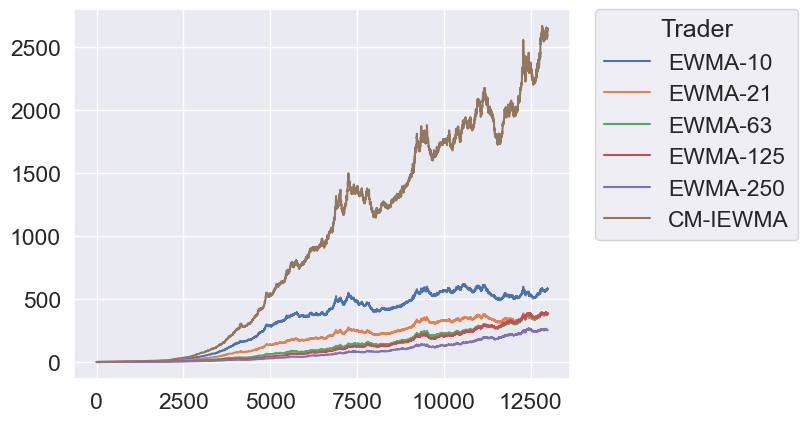

In [96]:
all_Vs = np.array([traders_mean_var[trader].Vs for trader in traders_mean_var]).reshape(-1,6)
all_Vs = pd.DataFrame(all_Vs, columns=names)

for trader in traders_mean_var:
    plt.plot(traders_mean_var[trader].Vs, label=trader)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Trader");

In [39]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-10 & 8.3\% & 6.0\% & 1.4 & 28\% \\
   EWMA-21 & 7.5\% & 6.1\% & 1.2 & 22\% \\
   EWMA-63 & 7.4\% & 6.2\% & 1.2 & 16\% \\
   EWMA-125 & 7.5\% & 6.1\% & 1.2 & 18\% \\
   EWMA-250 & 6.7\% & 6.0\% & 1.1 & 20\% \\
   CM-IEWMA & 11.2\% & 6.7\% & 1.7 & 24\% \\
   \hline


KeyError: 'PRESCIENT'

In [30]:
pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]

# compute the covariance matrices, one time series for each pair
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], clip_at=10000, min_periods_vola=63, min_periods_cov=63, mean=True)) for pair in pairs}
means = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

Sigmas["10-21"] = add_to_diagonal(Sigmas["10-21"], lamda=0.05)

In [31]:
combinator = CovarianceCombination(Sigmas=Sigmas, returns=returns, means=means)
results = list(combinator.solve_window(window=10, verbose=True))

100%|██████████| 3138/3138 [00:34<00:00, 90.08it/s] 


In [32]:
from collections import namedtuple

pred = namedtuple("pred", ["time", "mean", "covariance", "weights"])

cm_iewma_mean = {result.time: result.mean for result in results}
cm_iewma_cov = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}
times = [result.time for result in results]

cm_iewma = pred(times, cm_iewma_mean, cm_iewma_cov, weights)

In [33]:
# Prescient 
covs = {}
means = {}
times = []
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].mean().values
    covs[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)
    means[t] = pd.Series(mean, index=returns.columns)
    times.append(t)
prescient = pred(times, means, covs, None)

# Quarterly Fama-French factors

In [177]:
returns = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)
print("Average daily returns: ", returns.mean())
# Get quarterly returns
returns = returns.resample('Y').apply(lambda x: (x + 1).prod() - 1)
print("Average quarterly returns: ", returns.mean())

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

rf_rate = rf_rate.resample('Y').apply(lambda x: (x + 1).prod() - 1)

Average daily returns:  Mkt-RF    0.000265
SMB       0.000075
HML       0.000154
RMW       0.000138
CMA       0.000141
dtype: float64
Average quarterly returns:  Mkt-RF    0.068991
SMB       0.021874
HML       0.044183
RMW       0.036816
CMA       0.038676
dtype: float64


In [1]:
returns.shape

NameError: name 'returns' is not defined

In [179]:
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=1, min_periods_cov=6)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

cm_iewma_ff_no_mean = {result.time: result.covariance for result in results}
weights_ff_no_mean = {result.time: result.weights for result in results}

In [180]:
### With mean adjustment
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63)]
mean_pairs = [(10, 10), (21, 21), (63, 63)]
K = len(mean_pairs)

# CM-IEWMA
iewmas = {i: list(iterated_ewma(returns, vola_halflife=cov_pairs[i][0], cov_halflife=cov_pairs[i][1], min_periods_vola=1, min_periods_cov=6, mean=True, mu_halflife1=mean_pairs[i][0], mu_halflife2=mean_pairs[i][1])) for i in range(K)}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
mus = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast =0
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_with_mean = list(from_sigmas(Sigmas, returns, means=mus).solve(window=10))

cm_iewma_ff_with_mean = {result.time: result.covariance for result in results_with_mean}
means = pd.DataFrame({result.time: result.mean for result in results_with_mean}).T
weights_ff_with_mean = {result.time: result.weights for result in results_with_mean}

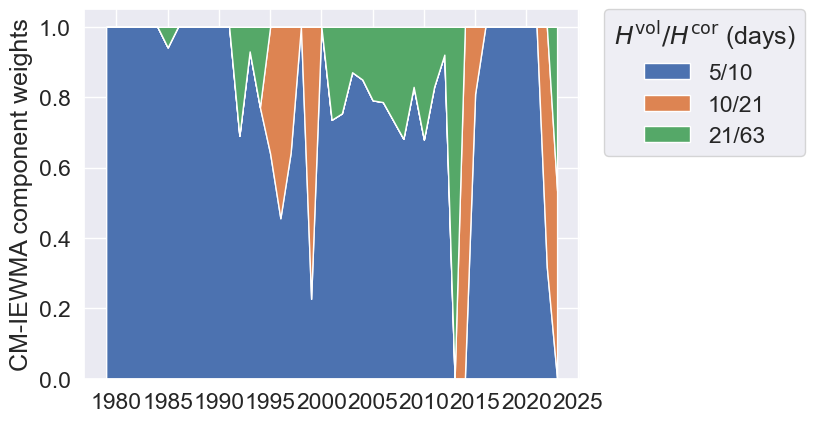

In [181]:
yearly_weights  = pd.DataFrame(weights_ff_no_mean).T

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

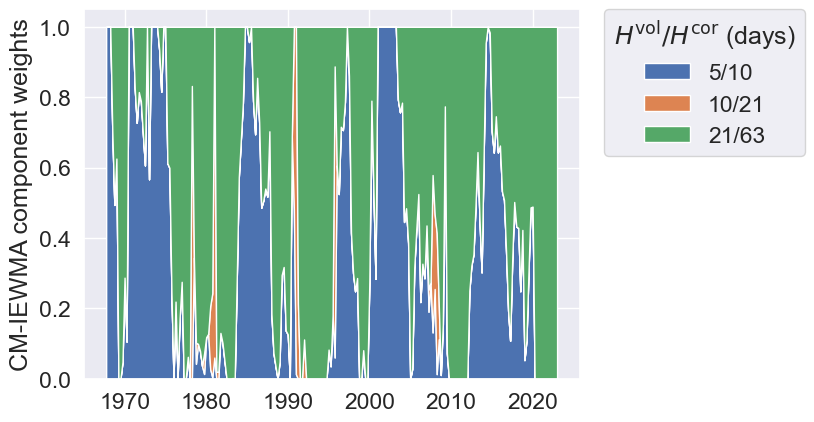

In [81]:
yearly_weights  = pd.DataFrame(weights_ff_with_mean).T

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

In [182]:
means = returns.ewm(halflife=63, min_periods=0).mean()

In [183]:
from experiments.utils.experiment_utils import log_likelihood_regularized


In [185]:
means = returns.ewm(halflife=50, min_periods=0).mean()
ll_no_mean2 = log_likelihood_regularized(returns, cm_iewma_ff_no_mean, r=None, means=means)
ll_no_mean2.mean()

3.5007628486262146

<Axes: >

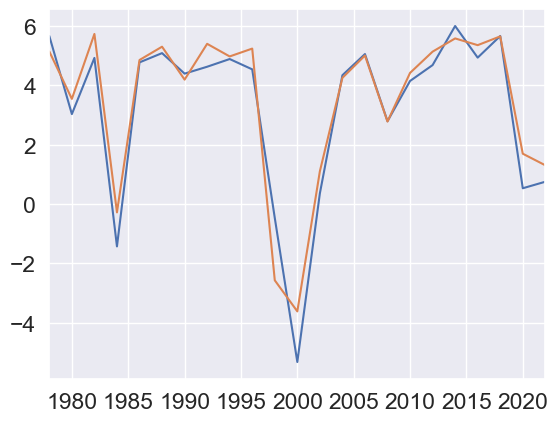

In [187]:
ll_no_mean.resample("2Y").mean().plot()
ll_no_mean2.resample("2Y").mean().plot()

In [186]:
ll_no_mean = log_likelihood_regularized(returns, cm_iewma_ff_no_mean, r=None)
ll_no_mean.mean()

3.2181141704236653

In [191]:
Sigma_temp = {time: cm_iewma_ff_no_mean[time] for time in cm_iewma_ff_with_mean.keys()}

In [207]:
ll_with_mean = log_likelihood_regularized(returns, cm_iewma_ff_with_mean, r=None, means=means)
ll_with_mean.mean()

3.2340624237480755

In [193]:
ll_no_mean.mean()

3.2181141704236653

In [194]:
ll_with_mean.mean()

3.4625557521036994

<Axes: >

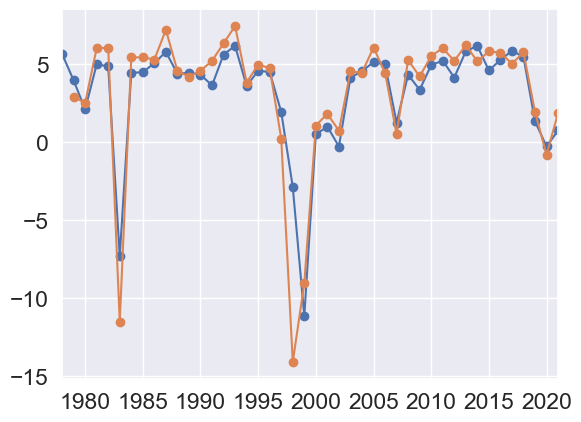

In [208]:
ll_no_mean.plot(marker="o")
ll_with_mean.plot(marker="o")
# plt.ylim(-10,15)

(-10.0, 15.0)

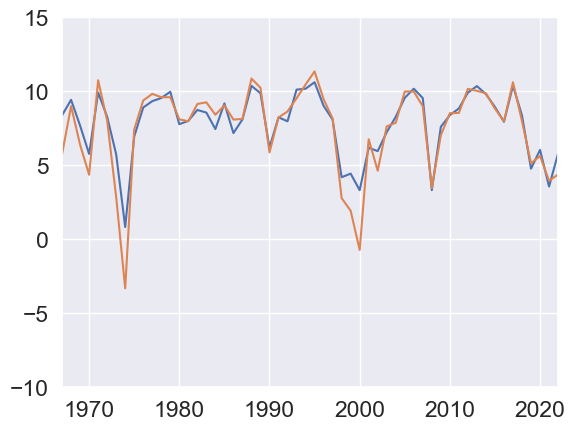

In [100]:
ll_no_mean.resample("Y").mean().plot()
ll_with_mean.resample("Y").mean().plot()
plt.ylim(-10,15)

# Portfolios

In [109]:
from experiments.utils.portfolio_backtests import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

In [110]:
names = ["No mean", "With mean"]
predictors = [cm_iewma_ff_no_mean, cm_iewma_ff_with_mean]
start_date = [*cm_iewma_ff_with_mean.keys()][0]
end_date = [*cm_iewma_ff_with_mean.keys()][-1]
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


In [101]:
names

['EWMA-21', 'EWMA-63', 'EWMA-125', 'EWMA-250', 'EWMA-500', 'CM-IEWMA']

In [100]:
traders_min_risk

{'EWMA-21': <experiments.utils.trading_model.Trader at 0x7fb70f1f3d30>,
 'EWMA-63': <experiments.utils.trading_model.Trader at 0x7fb70f29ac70>}

In [111]:
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No mean & 268.0\% & 12.4\% & 21.7 & 1\% \\
   With mean & 270.7\% & 12.5\% & 21.6 & 0\% \\
   \hline
   \bottomrule
\end{tabular}
